**Описание Задачи.** 

Необходимо проверить что система сплитования работает корректно.  Для этого мы проведем множественные А-А  тесты с использованием бутстрэп. Принимаем  p-вэлью - 0,05. То есть значимые различия мы должны обнаружить не чаще чем в 5% случаев.


Сравним группу 0 и 1 между собой. Проведем 10 000 А-А тестов между выборками сгенирироваными бутстрепом с повторениями. Будем генерировать простым бутстрепом. Проведем сравнение этих подвыборок t-testом.


In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline

from scipy.stats import mannwhitneyu

c:\Users\todur\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# создаёт словарь с именем connection, который содержит информацию для подключения к базе данных ClickHouse.
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [3]:
# скачиваем данные из clickhouse группы 0 и 1. С '2021-11-14' по '2021-11-20'
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2021-11-14' and '2021-11-20' and exp_group in (0,1)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)


In [4]:
# посмотрим как выглядят наши данные
df.head(3)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575


In [5]:
# посмотрим размер обоих групп
df.groupby('exp_group',as_index =False).agg({'user_id':'count'}) 

,exp_group,user_id
0,0,9849
1,1,9990


In [6]:
# разделим по группам
group_A = df[df.exp_group == 0].copy()
group_B = df[df.exp_group == 1].copy()

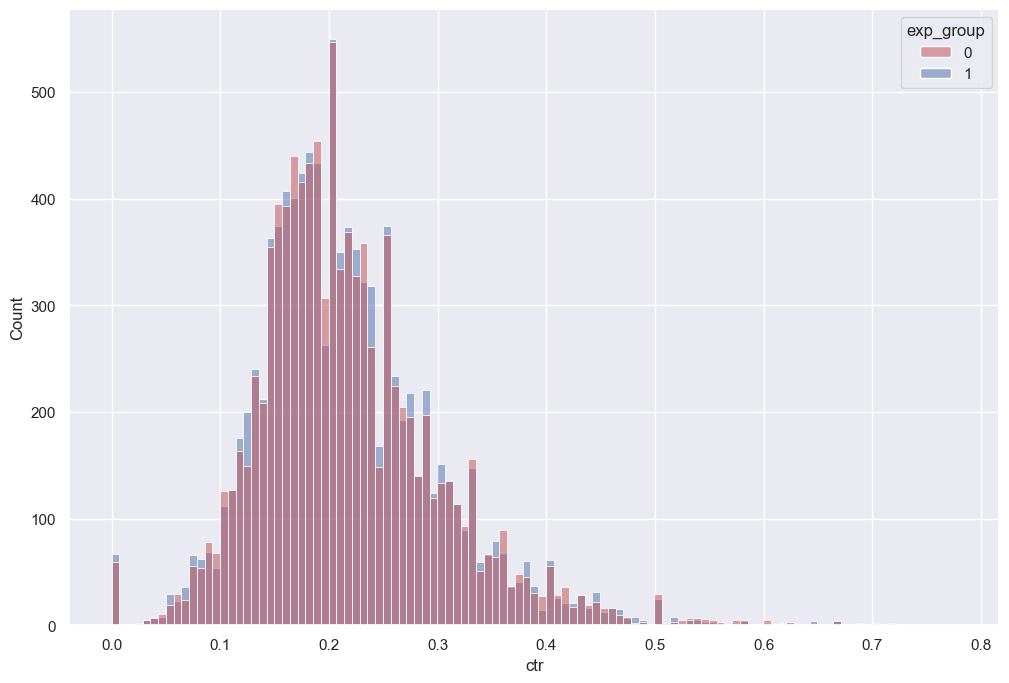

In [7]:
# посмотрим как распределен CTR по группам
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data =df
                     ,x='ctr'
                     ,hue='exp_group'
                     ,palette = ['r','b']
                     ,alpha=0.5
                     ,kde=False)

Визуально CTR по группам одинаковый.

In [8]:
# симуляция подвыборок 
ps = []
for i in range(10000):
    _, p_value = stats.ttest_ind(group_A.ctr.sample(frac=1, replace=True), 
                                 group_B.ctr.sample(frac=1, replace=True),
                                 equal_var = False)
    ps.append(p_value)

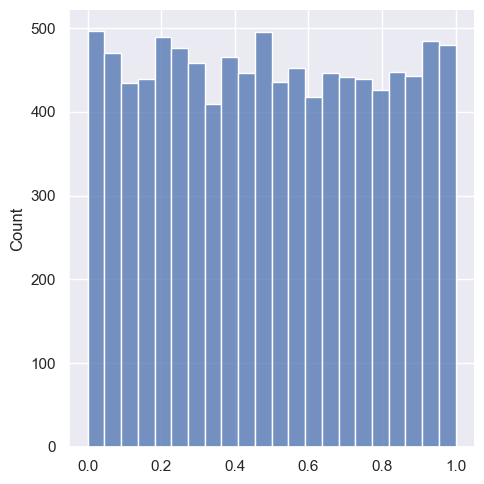

In [9]:
# посмотрим распределение
sns.displot(ps)

In [10]:
# Посчитаем, какой процент p values оказался меньше либо равен 0.05
temp_1 = sum(np.array(ps)<0.05) / 10000
display(f'Процет случаев когда у нас получились статистические значимые различия между 0 и 1 группой - {temp_1}')


'Процет случаев когда у нас получились статистические значимые различия между 0 и 1 группой - 0.0537'

**Вывод:**

Наша система сплитования работает корректно, так как всего 4.7% p-value из сделанных выборок меньше или равно a (0,05). Показатель ложноположительных оценок находится ниже его границы. То есть наши тестовые группы одинаковые.